In [ ]:
import torch
import torch.nn as nn
import fg_pre_process as prep
from fg_data_list import ImageList
import numpy as np
from torchvision import transforms

import fg_model_no_class as model_no

from sklearn.svm import LinearSVC

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    # ResizeImage(resize_size),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
  ])

## Define model

In [ ]:
class fine_net(nn.Module):
    def __init__(self, total_classes):
        super(fine_net, self).__init__()
        self.model_fc = model_no.Resnet50Fc()
        feature_len = self.model_fc.output_num()
        self.bottleneck_0 = nn.Linear(feature_len, 256)
        self.bottleneck_0.weight.data.normal_(0, 0.005)
        self.bottleneck_0.bias.data.fill_(0.1)
        self.bottleneck_layer = nn.Sequential(self.bottleneck_0, nn.ReLU())
        self.classifier_layer = predictor(256, total_classes)

    def forward(self, x):
        features = self.model_fc(x)
        out_bottleneck = self.bottleneck_layer(features)
        logits = self.classifier_layer(out_bottleneck)
        return out_bottleneck.detach(), logits.detach()
    
class predictor(nn.Module):
    def __init__(self, feature_len, cate_num):
        super(predictor, self).__init__()
        self.classifier = nn.Linear(feature_len, cate_num)
        self.classifier.weight.data.normal_(0, 0.01)
        self.classifier.bias.data.fill_(0.0)

    def forward(self, features):
        activations = self.classifier(features)
        return (activations)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        


## Load the source and target data

In [ ]:
dataset_list = ImageList("/newfoundland/tarun/datasets/Adaptation/", open("./data/visDA_126/clipart.txt").readlines(), transform=prep.image_test(resize_size=256, crop_size=224))
dataset_loader_source = torch.utils.data.DataLoader(dataset_list, batch_size=64, shuffle=False, num_workers=16, drop_last=False)

dataset_list = ImageList("/newfoundland/tarun/datasets/Adaptation/", open("./data/visDA_126/real.txt").readlines(), transform=prep.image_test(resize_size=256, crop_size=224))
dataset_loader_target = torch.utils.data.DataLoader(dataset_list, batch_size=64, shuffle=False, num_workers=16, drop_last=False)

## Collect features and labels for CDAN model

load_model = "clipart_real_cdan.pth.tar"
model = fine_net(126)
saved_state_dict = torch.load(load_model)
model.load_state_dict(saved_state_dict, strict=True)
model.eval()
model.cuda()

cdan_source_features = []
cdan_source_labels = []

cdan_target_features = []
cdan_target_labels = []

cdan_source_features = []
for i, (images , labels) in enumerate(dataset_loader_source):
    print(f"{i}/{len(dataset_loader_source)}", end="\r")
    images = images.cuda()
    features , _ = model(images)
    features = features.detach().cpu().numpy()
    labels = labels.numpy()
    
    cdan_source_features.append(features)
    cdan_source_labels.append(labels)
    
cdan_source_features = np.concatenate(cdan_source_features)
cdan_source_labels = np.concatenate(cdan_source_labels)
 

cdan_target_features = []
cdan_target_labels = []

for i , (images , labels) in enumerate(dataset_loader_target):
    print(f"{i}/{len(dataset_loader_target)}", end="\r")
    images = images.cuda()
    features , _ = model(images)
    features = features.detach().cpu().numpy()
    labels = labels.numpy()
    
    cdan_target_features.append(features)
    cdan_target_labels.append(labels)
    
cdan_target_features = np.concatenate(cdan_target_features)
cdan_target_labels = np.concatenate(cdan_target_labels)  

torch.save({"source_features":cdan_source_features, "source_labels":cdan_source_labels,
            "target_features":cdan_target_features, "target_labels":cdan_target_labels}, 
          "cdan_tsne.pth")

## Collect features for ILA model

load_model = "clipart_real_memsac.pth.tar"
model = fine_net(126)
saved_state_dict = torch.load(load_model)
model.load_state_dict(saved_state_dict, strict=True)
model.eval()
model.cuda()

memsac_source_features = []
memsac_source_labels = []

memsac_target_features = []
memsac_target_labels = []

memsac_source_features = []
for i, (images , labels) in enumerate(dataset_loader_source):
    print(f"{i}/{len(dataset_loader_source)}", end="\r")
    images = images.cuda()
    features , _ = model(images)
    features = features.detach().cpu().numpy()
    labels = labels.numpy()
    
    memsac_source_features.append(features)
    memsac_source_labels.append(labels)
    
memsac_source_features = np.concatenate(memsac_source_features)
memsac_source_labels = np.concatenate(memsac_source_labels)
 

memsac_target_features = []
memsac_target_labels = []

for i , (images , labels) in enumerate(dataset_loader_target):
    print(f"{i}/{len(dataset_loader_target)}", end="\r")
    images = images.cuda()
    features , _ = model(images)
    features = features.detach().cpu().numpy()
    labels = labels.numpy()
    
    memsac_target_features.append(features)
    memsac_target_labels.append(labels)
    
memsac_target_features = np.concatenate(memsac_target_features)
memsac_target_labels = np.concatenate(memsac_target_labels)  

torch.save({"source_features":memsac_source_features, "source_labels":memsac_source_labels,
            "target_features":memsac_target_features, "target_labels":memsac_target_labels}, 
          "memsac_tsne.pth")

## Source only baseline model

load_model = "clipart_Only.pth.tar"
model = fine_net(126)
saved_state_dict = torch.load(load_model)
model.load_state_dict(saved_state_dict, strict=True)
model.eval()
model.cuda()

baseline_source_features = []
baseline_source_labels = []

baseline_target_features = []
baseline_target_labels = []

baseline_source_features = []
for i, (images , labels) in enumerate(dataset_loader_source):
    print(f"{i}/{len(dataset_loader_source)}", end="\r")
    images = images.cuda()
    features , _ = model(images)
    features = features.detach().cpu().numpy()
    labels = labels.numpy()
    
    baseline_source_features.append(features)
    baseline_source_labels.append(labels)
    
baseline_source_features = np.concatenate(baseline_source_features)
baseline_source_labels = np.concatenate(baseline_source_labels)
 

baseline_target_features = []
baseline_target_labels = []

for i , (images , labels) in enumerate(dataset_loader_target):
    print(f"{i}/{len(dataset_loader_target)}", end="\r")
    images = images.cuda()
    features , _ = model(images)
    features = features.detach().cpu().numpy()
    labels = labels.numpy()
    
    baseline_target_features.append(features)
    baseline_target_labels.append(labels)
    
baseline_target_features = np.concatenate(baseline_target_features)
baseline_target_labels = np.concatenate(baseline_target_labels)  

torch.save({"source_features":baseline_source_features, "source_labels":baseline_source_labels,
            "target_features":baseline_target_features, "target_labels":baseline_target_labels}, 
          "baseline_tsne.pth")

## Start plotting for tSNE, separately for baseline, CDAN and MemSAC

In [4]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import torch
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_palette(sns.color_palette("hls", 13))

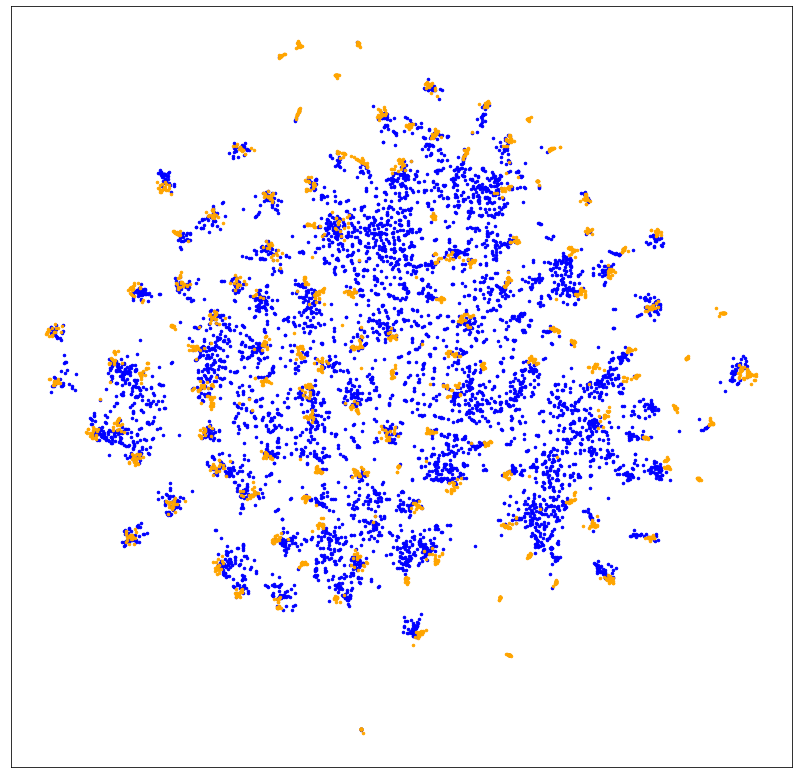

In [13]:
data = torch.load("baseline_tsne.pth")
source_features , source_labels , target_features, target_labels = \
    data["source_features"], data["source_labels"], data["target_features"], data["target_labels"]


## randomly subsample source
features = []
labels = []
for label_id in range(126):
    label_idxs = (source_labels == label_id).nonzero()[0]
    subidxs = label_idxs[:20]
    features.append(source_features[subidxs])
    labels.append(source_labels[subidxs])
source_features = np.concatenate(features)
source_labels = np.concatenate(labels)

## randomly subsample target
features = []
labels = []
for label_id in range(126):
    label_idxs = (target_labels == label_id).nonzero()[0]
    subidxs = label_idxs[:50]
    features.append(target_features[subidxs])
    labels.append(target_labels[subidxs])
target_features = np.concatenate(features)
target_labels = np.concatenate(labels)

len_source = len(source_features)
all_features = np.concatenate([source_features, target_features])
all_labels = np.concatenate([source_labels, target_labels])

tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(all_features)

source_tsne = tsne_embeddings[:len_source]
target_tsne = tsne_embeddings[len_source:]

plt.figure(figsize=(14,14))
plt.plot(target_tsne[:,0] , target_tsne[:,1] , linestyle='none', marker='o',markersize=2.5 , color="blue")
plt.plot(source_tsne[:,0] , source_tsne[:,1] , linestyle='none', marker='o',markersize=2.5 , color="orange")


plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.legend(prop={'size': 13} , markerscale=4)

plt.savefig("baseline_tSNE.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

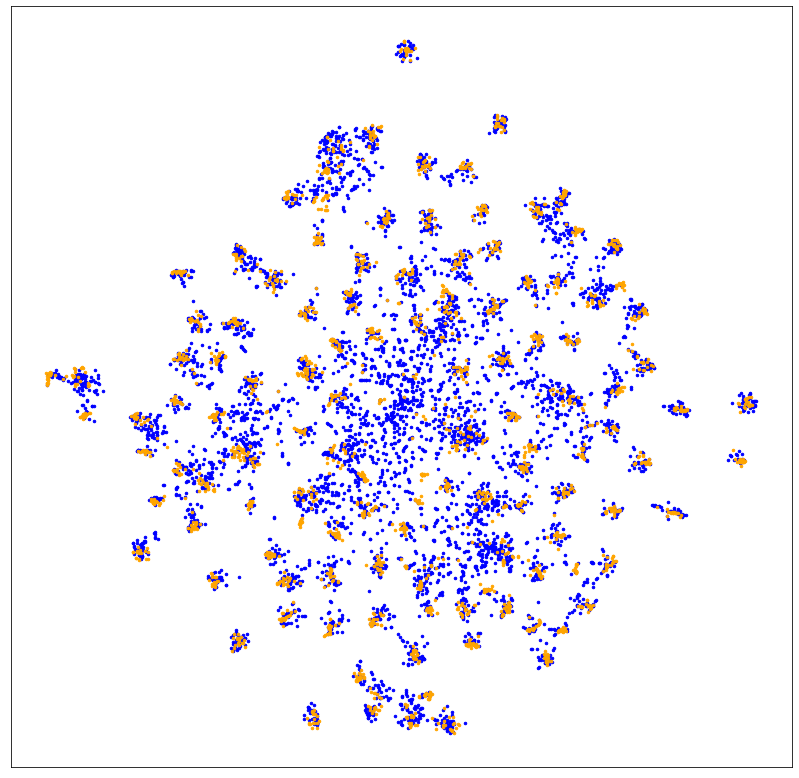

In [14]:
data = torch.load("cdan_tsne.pth")
source_features , source_labels , target_features, target_labels = \
    data["source_features"], data["source_labels"], data["target_features"], data["target_labels"]


## randomly subsample source
features = []
labels = []
for label_id in range(126):
    label_idxs = (source_labels == label_id).nonzero()[0]
    subidxs = label_idxs[:20]
    features.append(source_features[subidxs])
    labels.append(source_labels[subidxs])
source_features = np.concatenate(features)
source_labels = np.concatenate(labels)

## randomly subsample target
features = []
labels = []
for label_id in range(126):
    label_idxs = (target_labels == label_id).nonzero()[0]
    subidxs = label_idxs[:50]
    features.append(target_features[subidxs])
    labels.append(target_labels[subidxs])
target_features = np.concatenate(features)
target_labels = np.concatenate(labels)

len_source = len(source_features)
all_features = np.concatenate([source_features, target_features])
all_labels = np.concatenate([source_labels, target_labels])

tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(all_features)

source_tsne = tsne_embeddings[:len_source]
target_tsne = tsne_embeddings[len_source:]

plt.figure(figsize=(14,14))
plt.plot(target_tsne[:,0] , target_tsne[:,1] , linestyle='none', marker='o',markersize=2.5 , color="blue")
plt.plot(source_tsne[:,0] , source_tsne[:,1] , linestyle='none', marker='o',markersize=2.5 , color="orange")



plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("cdan_tSNE.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

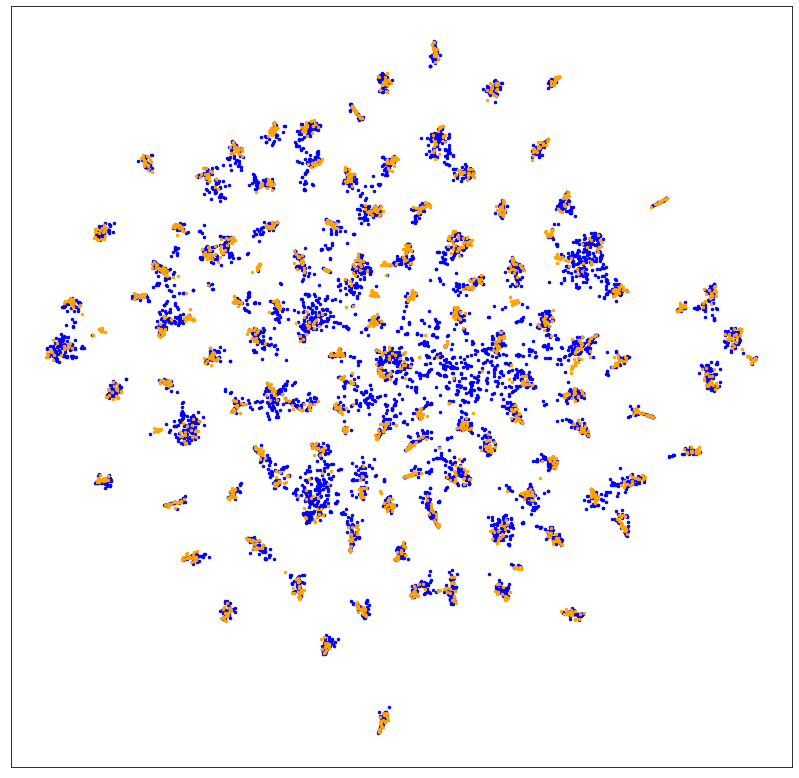

In [15]:
data = torch.load("memsac_tsne.pth")
source_features , source_labels , target_features, target_labels = \
    data["source_features"], data["source_labels"], data["target_features"], data["target_labels"]


## randomly subsample source
features = []
labels = []
for label_id in range(126):
    label_idxs = (source_labels == label_id).nonzero()[0]
    subidxs = label_idxs[:20]
    features.append(source_features[subidxs])
    labels.append(source_labels[subidxs])
source_features = np.concatenate(features)
source_labels = np.concatenate(labels)

## randomly subsample target
features = []
labels = []
for label_id in range(126):
    label_idxs = (target_labels == label_id).nonzero()[0]
    subidxs = label_idxs[:50]
    features.append(target_features[subidxs])
    labels.append(target_labels[subidxs])
target_features = np.concatenate(features)
target_labels = np.concatenate(labels)

len_source = len(source_features)
all_features = np.concatenate([source_features, target_features])
all_labels = np.concatenate([source_labels, target_labels])

tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(all_features)

source_tsne = tsne_embeddings[:len_source]
target_tsne = tsne_embeddings[len_source:]

plt.figure(figsize=(14,14))
plt.plot(target_tsne[:,0] , target_tsne[:,1] , linestyle='none', marker='o',markersize=2.5 , color="blue")
plt.plot(source_tsne[:,0] , source_tsne[:,1] , linestyle='none', marker='o',markersize=2.5 , color="orange")

plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("memsac_tSNE.pdf", format='pdf', dpi=1200, bbox_inches='tight')
plt.show()